In [3]:
from pathlib import Path

import polars as pl
import numpy as np
import pandas as pd
import pandas_dq
import missingno as msno
import sidetable
import miceforest as mf
from statsmodels.imputation import mice

In [4]:
data_path = Path("/Users/zacklarsen/Documents/Projects/kaggle-wids-datathon-2020/data/")
train_path = Path(data_path, "train.parquet")

In [5]:
X_train = pl.read_parquet(data_path / "X_train.parquet")
X_test = pl.read_parquet(data_path / "X_test.parquet")
y_train = pl.read_parquet(data_path / "y_train.parquet")
y_test = pl.read_parquet(data_path / "y_test.parquet")

In [6]:
X_train_sample = pd.DataFrame(X_train.limit(50))

In [7]:
X_train_sample

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184
0,59954,90449,118,86.0,28.16897519,0,Caucasian,M,170.2,Direct Admit,Accident & Emergency,100,admit,Neuro ICU,0.0,0,81.6,NA,301,408.02,0,0,NA,NA,NA,NA,4,6,0,5,70,44,NA,0,141,NA,NA,NA,NA,43,NA,36.4,NA,0,NA,NA,NA,106,56,106,56,80,44,NA,NA,141,76,141,76,43,7,100,97,NA,NA,175,123,175,123,36.8,36.3,NA,NA,68,64,68,64,62,54,NA,NA,NA,NA,NA,NA,24,10,100,100,NA,NA,168,155,168,155,36.3,36.3,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,164,70,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,4.1,4.1,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,95,95,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,0.05,0.01,0,0,0,0,0,0,0,0,Neurological,Neurologic
1,63518,19384,185,72.0,36.63508791,0,Caucasian,M,170.1,None,Accident & Emergency,687,admit,Med-Surg ICU,0.088889,0,106,NA,124,305.01,0,0,NA,NA,NA,NA,3,6,0,3,NA,105,29.3,0,50,NA,NA,NA,NA,34,NA,36.4,NA,0,NA,NA,NA,47,39,47,39,97,92,NA,NA,64,50,64,50,24,17,100,99,NA,NA,91,66,91,66,36.6,34.7,NA,NA,47,47,47,47,97,97,NA,NA,64,64,64,64,24,24,99,99,NA,NA,85,85,85,85,NA,NA,3.1,2.3,9.4,8.7,30,28,7.5,6.8,2.2,2,476,125,12,7,9.8,5.8,29.3,16.4,2.4,1.4,13.7,11.7,65,55,4.6,4,141,125,16.7,16.2,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,2.4,1.4,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,20,16,7.29,7.25,427,114,427,427,NA,NA,NA,NA,NA,NA,NA,NA,0.04,0.02,0,0,0,0,0,0,0,0,Gastrointestinal,Gastrointestinal
2,34401,20558,188,36.0,27.45968419,0,African American,M,162.6,Emergency Department,Accident & Emergency,840,admit,MICU,0.044444,0,72.6,NA,122,703.03,0,0,NA,6,0.77,NA,4,6,0,5,122,103,35.8,0,55,NA,NA,NA,NA,13,141,36.7,4571.5968,0,9.4,NA,NA,80,45,80,45,103,69,NA,NA,91,55,91,55,22,13,100,93,NA,NA,135,91,135,91,36.9,36.7,NA,NA,77,57,77,57,99,85,NA,NA,88,70,88,70,21,14,99,94,NA,NA,135,102,135,102,36.7,36.7,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,128,128,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,0,0,0,0,0,0,0,0,0,0,Metabolic,Metabolic
3,71581,112066,62,60.0,21.97735112,0,Caucasian,M,181,Emergency Department,Accident & Emergency,481,admit,MICU,0.213194,0,72,NA,305,901.03,0,0,NA,127,7.9,0.5,4,5,0,4,279,144,19.3,0,193,28.4,28.4,122.8,7.43,31,139.9,35,NA,0,8.4,60,33,69,35,69,35,133,83,81,43,112,42,112,42,29,12,100,90,121,66,123,69,123,69,37.4,35,NA,NA,37,35,37,35,121,117,NA,NA,49,42,49,42,29,29,94,94,NA,NA,75,69,75,69,NA,NA,NA,NA,NA,NA,126,113.09,8.1,6.5,7.9,4.56,279,174,20,8,10.1,6.5,22.4,19.3,NA,NA,3.15,1.2,240,184,5.5,4.06,143,136.4,13.8,8.4,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,10.1,10.1,NA,NA,NA,NA,3.15,3.15,NA,NA,5.31,5.31,136.4,136.4,NA,NA,28.4,18.7,7.43,7.21,122.8,81.2,386.6666667,245.6,18.7,18.7,7.21,7.21,81.2,81.2,386.6666667,386.6666667,0.12,0.06,0,0,0,0,0,0,0,0,Genitourinary,Renal/Genitourinary
4,29019,129440,161,27.0,19.960244,0,Caucasian,F,177.8,Emergency Department,Accident & Emergency,413,admit,Med-Surg ICU,0.052083,0,63.1,2.5,113,501.04,0,0,0.3,10,0.66,NA,4,6,0,5,70,120,21.3,0,63,NA,NA,NA,NA,32,134,36.6,3560.3712,0,45,NA,NA,70,48,70,48,119,70,NA,NA,78,63,78,63,32,14,100,94,NA,NA,118,91,118,91,38.4,36.6,NA,NA,67,56,67,56,97,78,NA,NA,74,63,74,63,20,18,98,96,NA,NA,114,91,114,91,36.6,36.6,2.8,2.5,0.3,0.2,10,9,8.6,8.1,0.67,0.66,172,70,24,19,7.8,7.3,22.5,21.3,1.4,1.4,NA,NA,27,18.55,4.1,2.9,139,134,45,30.3,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,172,17

## Polars

In [14]:
X_train.glimpse()

Rows: 73370
Columns: 185
$ encounter_id                  <i64> 59954, 63518, 34401, 71581, 29019, 70076, 63091, 40553, 75009, 94808
$ patient_id                    <i64> 90449, 19384, 20558, 112066, 129440, 97970, 42207, 499, 125636, 104142
$ hospital_id                   <i64> 118, 185, 188, 62, 161, 89, 161, 186, 62, 128
$ age                           <f32> 86.0, 72.0, 36.0, 60.0, 27.0, 71.0, 35.0, 75.0, 72.0, 50.0
$ bmi                           <str> '28.16897519', '36.63508791', '27.45968419', '21.97735112', '19.960244', '21.31254263', '29.34003963', '29.1796875', '24.24339532', '22.3046875'
$ elective_surgery              <i64> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
$ ethnicity                     <str> 'Caucasian', 'Caucasian', 'African American', 'Caucasian', 'Caucasian', 'Other/Unknown', 'Hispanic', 'Caucasian', 'Caucasian', 'Caucasian'
$ gender                        <str> 'M', 'M', 'M', 'M', 'F', 'F', 'F', 'F', 'M', 'F'
$ height                        <str> '170.2', '170.1', '162.6',

In [15]:
null_counts = X_train.null_count()

In [16]:
null_counts

encounter_id,patient_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,…,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,…,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,3387,0,0,1106,17,0,17092,88,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1295,1295


In [ ]:
null_counts = null_counts.filter()

In [ ]:
null_counts

In [ ]:
# Print column names and number of missing values
for col_name, count in zip(null_counts.columns, null_counts.to_list()[0]):
    print(f"{col_name}: {count}")

In [ ]:
# Create a binary column indicating missingness
df['A_missing'] = df['A'].isnull().astype(int)

# Check correlation of missingness with other variables
correlations = df.corr()['A_missing'].drop('A_missing')

In [8]:
X_train_pd = X_train.to_pandas()

<Axes: >

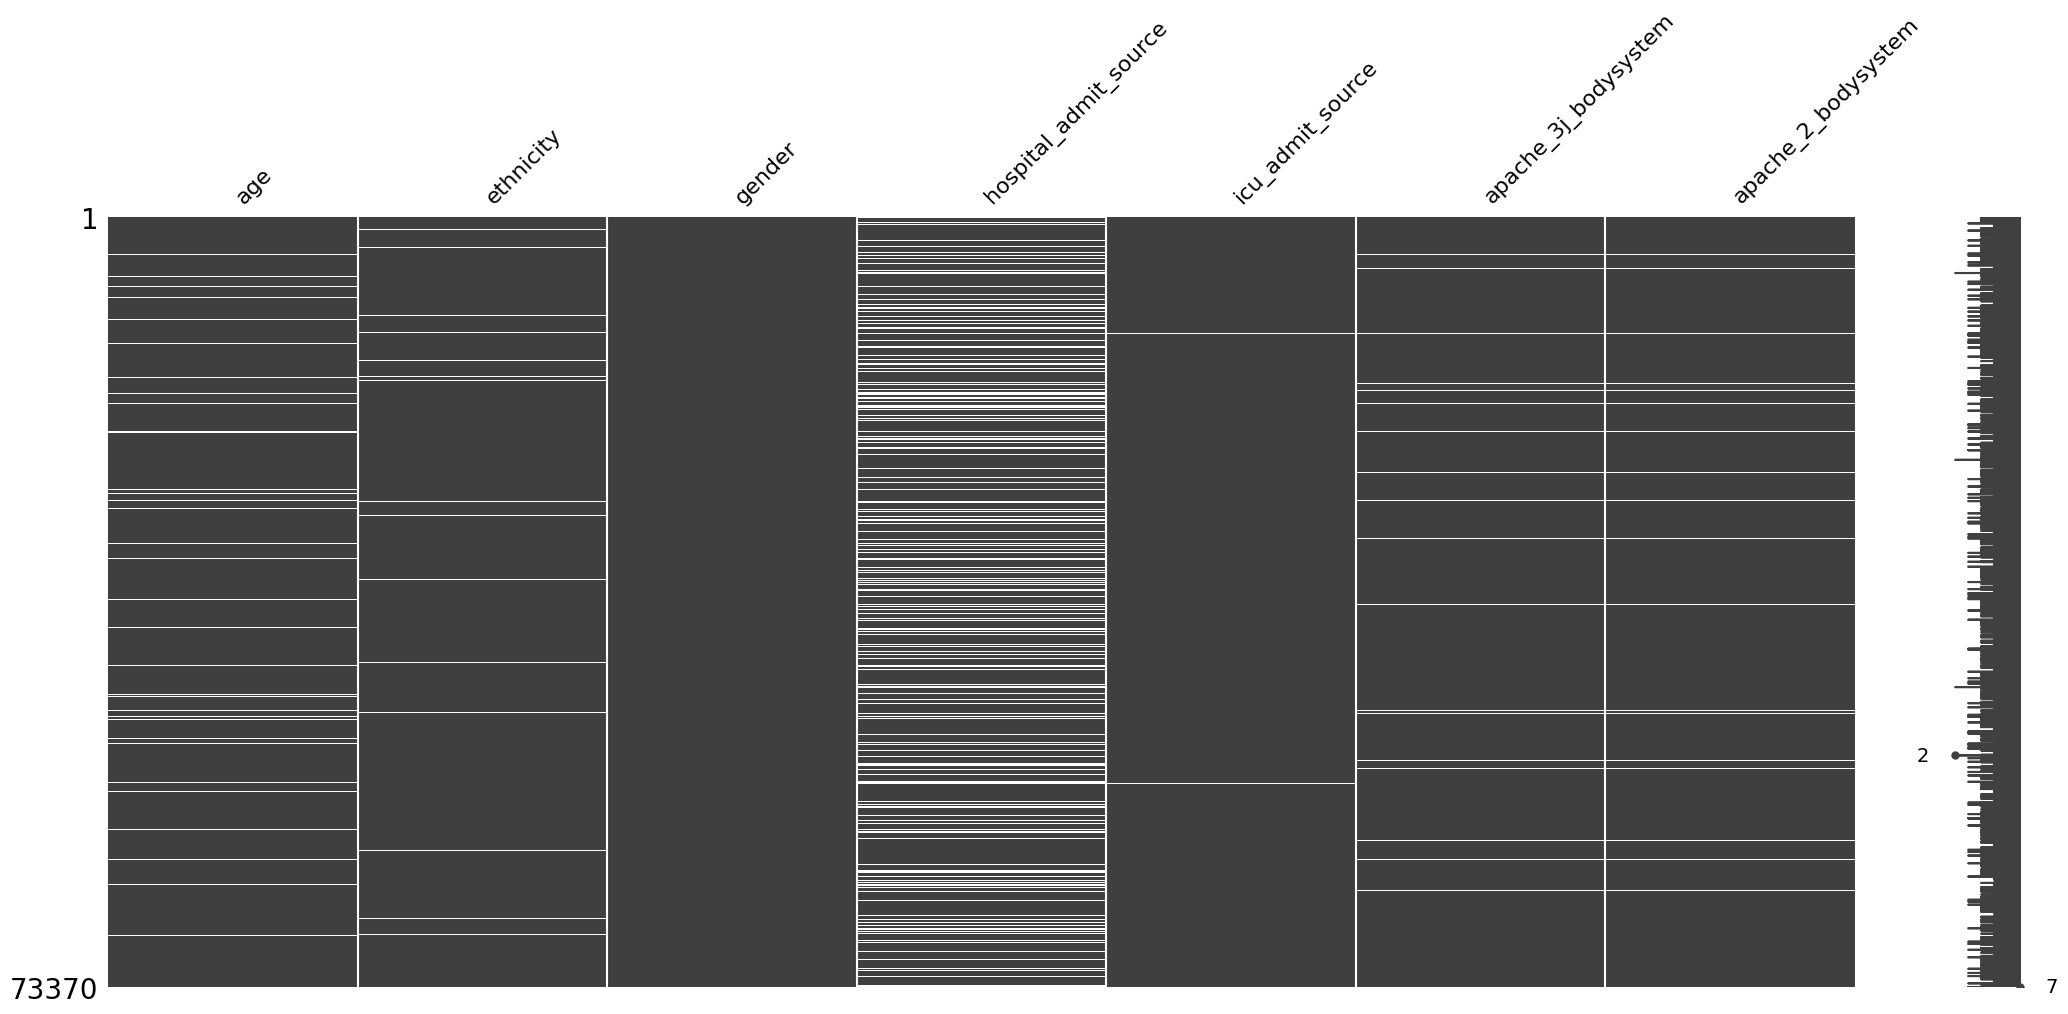

In [9]:
msno.matrix(X_train_pd[X_train_pd.columns[X_train_pd.isnull().any()]])

<Axes: >

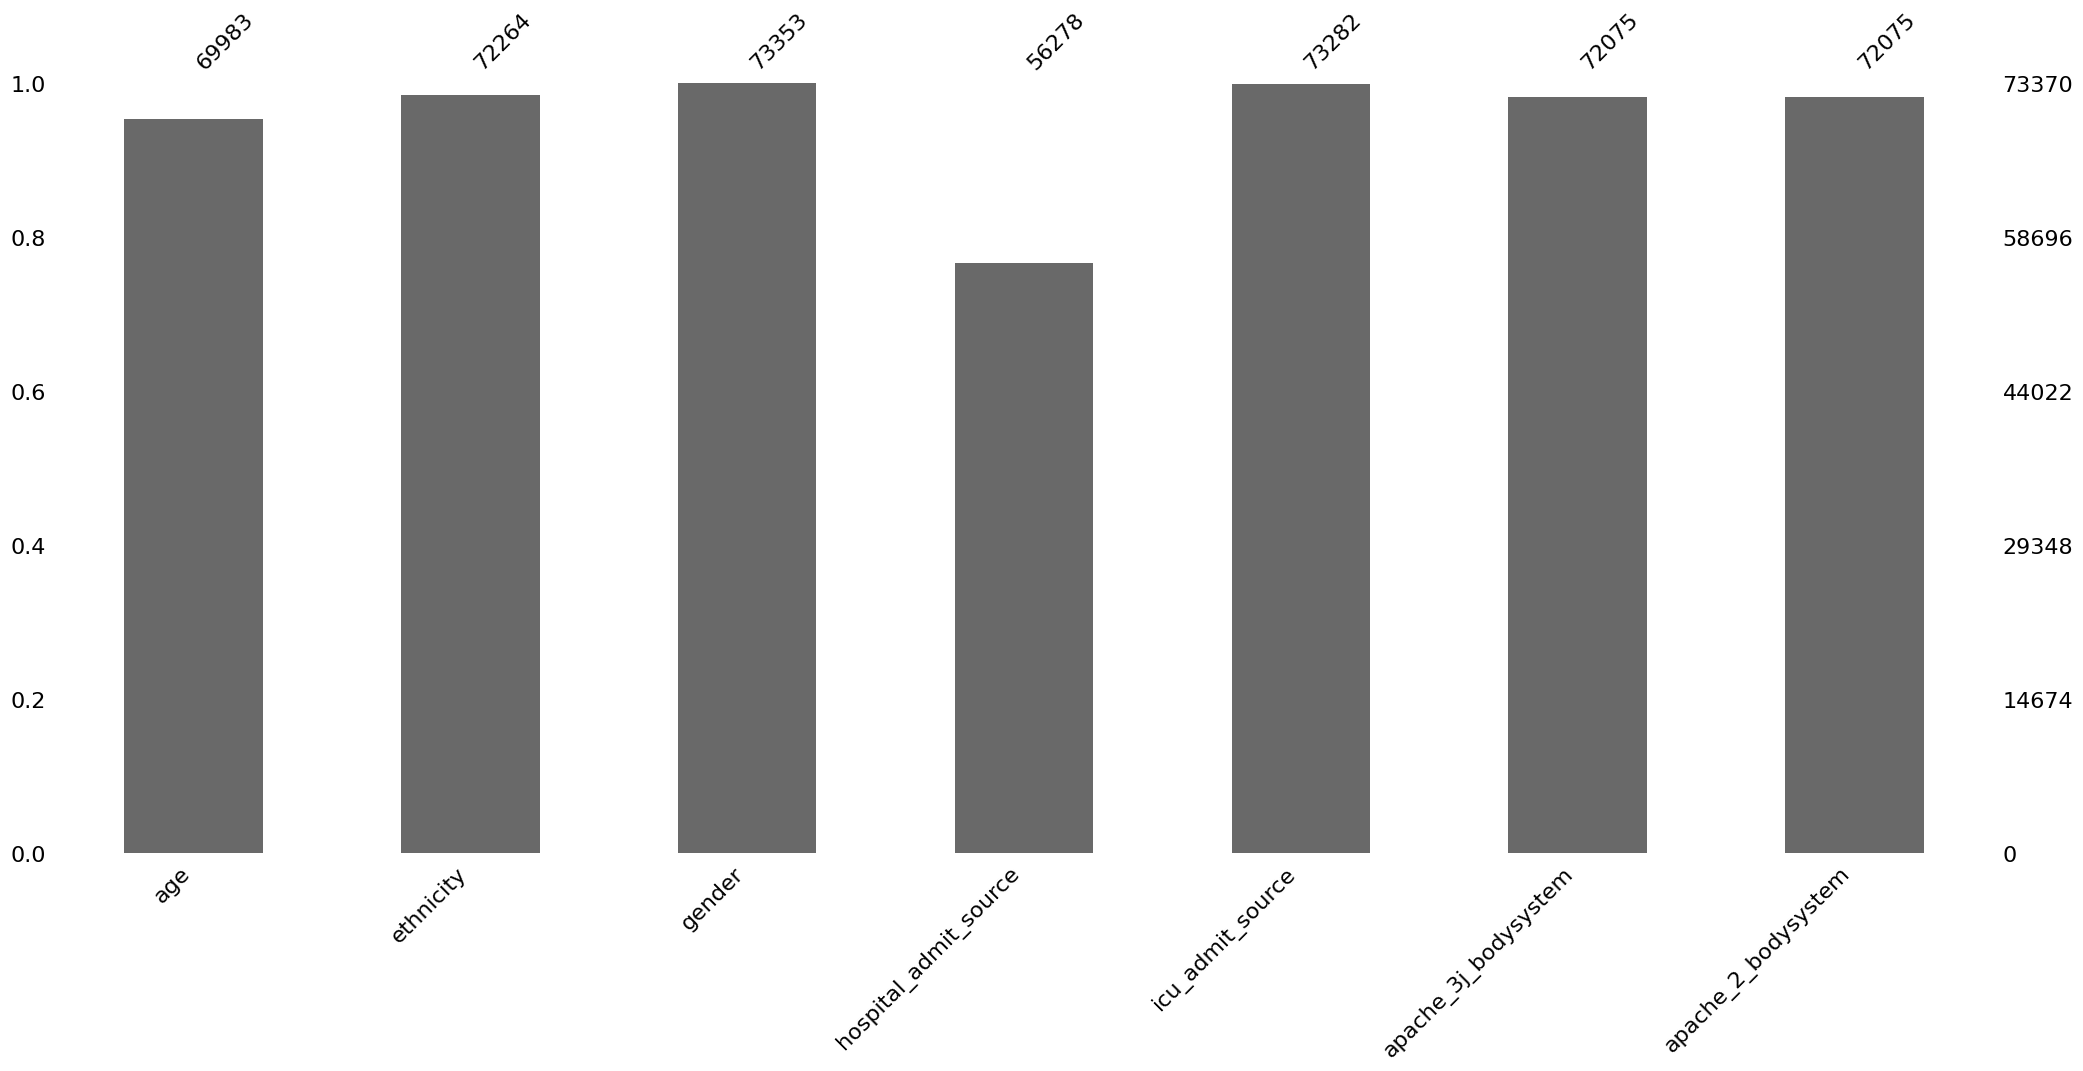

In [10]:
msno.bar(X_train_pd[X_train_pd.columns[X_train_pd.isnull().any()]])

## miceforest

https://pypi.org/project/miceforest/

In [11]:
# Create kernel. 
kds = mf.ImputationKernel(
  X_train_pd,
  save_all_iterations=True,
  random_state=42
)

ValueError: Please convert object columns to categorical or some numeric type.

In [ ]:
# Run the MICE algorithm for 2 iterations
kds.mice(2)

In [ ]:
# Return the completed dataset.
X_train_complete = kds.complete_data()